**Remember `shift + enter` to run a cell**

Versions of this file will be updated at [www.github.com/bhclowers](https://github.com/bhclowers/scriptorium/tree/master/Ion%20Mobility%20Calculator)

# *<center> Ion Mobility Calculator </center>*

### The following set of code outlines the general principles to calculate the gas phase mobility from drift tube IMS experiments.  Specific functions include:
* Drift time to (non-field corrected) ion-neutral cross section conversion.
* CCS to Drift Time Conversion
* Ion mobility simulator accepting key experimental parameters to predict drift time with contributions from diffusion
* Corrections to the fundamental ion mobility equation for electric field strength. 

### Conventions used in this document: 
* lowercase variables are associated with the ion
* uppercase variables are associated with the neutral

Perhaps the most important aspect to this notebook is the field-strength correction approach. As outlined by Siems, Viehland, and Hill, the intial derivation of the equation often used to calculate the ion-neutral cross section of an ion assumes *zero-field* strength. However, we know this to not be the case simply by the nature of the ion mobility experiment (i.e. we require an electric field to measure the mobility experiment).  Interestingly, the Langevin (aka as the Mason-Shamp Equation) can also be derived from the Nernst-Einstein relationship and Fick's Law of diffusion--neither of which require and electric field. 

In the papers referenced below, Bill, Larry, and Herb (BLH) illustrate that when the influence of the electric field is considered the forces governing the momentum transfer between an ion and neutral change.  It is well known that at extremem electric fields (i.e. E/N values), the gas-phase coefficient of mobility is not constant.  Moreover, it has been assumed that drift tube experiments conducted at reduced pressure (e.g. 4 torr) operate under the "low-field limit" as described by Revercomb and Mason (Analytical Chemistry, 1975).  It should be noted, that this E/N value reported by Revercomb and Mason is not necessarily incorrect but makes key assumptions that do not always hold for large polyatomic systems.  In the papers by BLH the concept of electric field strength and its impact on observed mobility is cast in terms of drift velocity of the ion and the thermal velocity of the gas.  A key assumption of the mobility experiment is that the applied electric field should minimally impact the energy of the ion with the ion system being largely thermalized by the gas.  Stated differently, if the electric field is too high then the ion energy is distorted relative to the gas temperature. Under stuch conditions the ion mobility theory breaksdown--in more ways than one.  To be clear, the boundary between the low and high electric field limit not discrete. Rather, it is different for each ion and the choice of experimental parameters is up to the experimentalist.    

Careful reading of the BLH papers highlights that failure to account for field effects can lead to errors of up to 4 percent in common low pressure IMS cells.  Such errors may not impact precision and may falsely impart a sense of accuracy.  Moreover, in the common drift cell IMS experiment different electric fields are often used in the construction of common P/V plots.  However, these plots assume that there is no real change in CCS with field.  As evidenced by experiments conducted in our own lab, these plots are still quite linear, it is just that in the input values need to correct for the relative contributions from the field.  

Finally, a key difference between the core Mason-Schamp/Langevin treatment of ion mobility and that presented by BLH is that the latter provides a direct mechnism correct the mobility equation so that the key assumptions that give rise the to 3/16 and the 3/4 fractions are not just approximations but linked directly to the experimental parameters.  At the risk of being redundant...To be clear, if the goal of the IMS community is to strive for accuracy and reproducibility then corrections to the reported mobility values should be reported.  As the schemes below illustrate, it is not a complicated process and requires but a few simple, extra steps.

## Eqn #1:     $$\Omega=\bigg(\dfrac{3}{16}\bigg)\bigg(\dfrac{2\pi}{\mu\mathrm{k_{b}}\mathrm{T}}\bigg)^{\frac{1}{2}}\bigg(\dfrac{ze}{KN}\bigg)=\dfrac{3}{4}\bigg(\dfrac{zeE}{\mu\mathrm{v_d}\mathrm{v_T}N}\bigg)$$

#### Relevant References

* Improved Momentum-Transfer Theory for Ion Mobility. 1. Derivation of the Fundamental Equation
    * William F. Siems, Larry A. Viehland, and Herbert H. Hill, Jr.
        * dx.doi.org/10.1021/ac301779s
        
* Correcting the fundamental ion mobility equationfor field effects
    * William F. Siems, Larry A. Viehland and Herbert H. Hill, Jr
        * DOI: 10.1039/c6an01353h

    

#### The image below, taken directly from BLH, illustrates the types of collisions between the ion and the neutral.  Some may be heating and others may be cooling.  It is this ratio that needs to be calculated below to correct for the impact of the electric field. 

![Heating and Cooling Conditions](Heating and Cooling Collisions.PNG)

### Standard Python Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# %matplotlib notebook

In [2]:
from scipy import constants

In [3]:
from scipy import interpolate

### Parameters of the Drift Cell and Experiment
* Change to suit your system

In [5]:
DL = 10  #in cm
DV = 4500  #in volts

P = 690  #torr
GM = 28  #gas mass in amu

PW = 150  #in microseconds
# PULSE_WIDTH /=1E6 #Convert to seconds
STARTTIME = 0  #ms
SCAN_TIME = 72  #ms

### Experimental Mobility Equations

## Eqn #2:     $$\mathrm{K}=\dfrac{v_{d}}{\mathrm{E}}=\dfrac{\mathrm{L}^2}{t_d\cdot \mathrm{V}}$$   

## Eqn #3:     $$\mathrm{K}_0=\mathrm{K}\cdot \dfrac{273.15}{\mathrm{T}}\cdot \dfrac{\mathrm{P}}{760}$$

In [6]:
def mobilityFromDriftTime(driftTime, length, voltage):
    '''
    See Equation #2
    '''
    mobility = length**2 / (driftTime * voltage)
    return mobility

In [7]:
def getReducedMobility(mobility, pressure, temp):
    '''
    Temp should be in Kelvin
    Pressure in Pressure
    Mobility in cm**2 V**-1 s**-1
    '''
    #     print mobility
    #     print 273.15/temp
    #     print pressure/760
    kRed = mobility * ((273.15) / temp) * (pressure / (760.0))
    return kRed

In [8]:
dt = 24.52
dt /= 1000.0  #in seconds
mob = mobilityFromDriftTime(dt, DL, DV)
mob  #in cm^2/Vs

0.906289650172195

In [68]:
T = 150
T += 273.15
P = 690
kRed = getReducedMobility(mob, P, T)
print(kRed)

0.531140451568528


In [11]:
def driftTimeFromReducedMobility(reducedMobility, pressure, temp, length,
                                 voltage):
    '''
    Mobility values are in cm^2/Vs
    Length is in cm
    returns drift time in seconds
    
    '''
    tempTerm = 273.15 / (temp)  #don't forget to convert to K before submission
    pressureTerm = pressure / (760.0)
    mobilityTerm = length**2 / (voltage * reducedMobility)
    driftTime = tempTerm * pressureTerm * mobilityTerm  #
    return driftTime

In [12]:
driftTimeFromReducedMobility(kRed, P, T, DL, DV)

0.02452

## Eqn #1:     $$\Omega=\bigg(\dfrac{3}{16}\bigg)\bigg(\dfrac{2\pi}{\mu\mathrm{k_{b}}\mathrm{T}}\bigg)^{\frac{1}{2}}\bigg(\dfrac{ze}{KN}\bigg)=\dfrac{3}{4}\bigg(\dfrac{zeE}{\mu\mathrm{v_d}\mathrm{v_T}N}\bigg)$$

## Eqn #4:    

## Thermal Velocity: $$\mathrm{v_T}=\bigg(\dfrac{8kT}{\pi\mu}\bigg)^{\frac{1}{2}}$$

In [13]:
def calcThermalVelocity(temp, mu):
    '''
    temp is in K
    mu = reduced mass
    return value is meter/sec
    '''
    kb = 1.38065E-16  #erg/K
    amu = 1.660539E-24  #gm
    vt = (8 * kb * temp / (np.pi * mu * amu))
    vt = np.sqrt(vt) / 100
    return vt

In [14]:
def calcNumberDensity(press, temp,
                      No=2.68677E25):  # change to 2.68677E19 if you want cm^-3
    '''
    Calculate molecular number density
    Pressure is in torr
    Temp is in Kelvin
    return value is in units of m^-3
    '''
    return No * (273.15 / temp) * (press / 760.0)

In [15]:
calcThermalVelocity(423.15, 26.587)

580.49678735821738

In [92]:
def ccsFromDriftTime(voltage,
                     length,
                     pressure,
                     temp,
                     driftTime,
                     charge,
                     ionMass,
                     gasMass,
                     debug=False):
    '''
    ccs is in square angstroms
    pressure is in torr
    length is in cm
    Temp is in Kelvin
    ionMass and gasMass are in amu
    ccs in in squared length units
    '''
    kb = constants.k
    LC = 2.6867774e25  #Loschmidt Constant in m^-3
    massConv = 1.660539E-24  #gm/amu
    length /= 100.0  #in m
    numberDensity = calcNumberDensity(pressure, temp)

    #<vT>=(8kT/πμ)1/2 (m s-1)
    reducedMass = ((ionMass * gasMass) / (ionMass + gasMass))
    thermalVelocity = calcThermalVelocity(temp, reducedMass)  #m/s
    vd = length / driftTime
    if debug:
        print("Drift Velocity in m/s:", vd)
    eField = voltage / (length)  #V/m
    numerator = 0.75 * charge * constants.e * eField / numberDensity / 1.0E-17  #Townsend factor
    denominator = reducedMass * massConv * thermalVelocity * vd
    ccs = numerator / denominator * 1E6  #scaling factor for units
    if debug:
        print("E-Field: ", eField / 100, 'V/cm')
        print("Drift Velocity", vd, "m/s")
        print("Thermal Velocity: ", thermalVelocity)
        print("Number Density: ", numberDensity)
        print("Numerator: ", numerator)
        print("Denominator: ", denominator)

    return ccs  # in square angstroms

In [93]:
ccsFromDriftTime(DV, DL, P, T, dt, 1, 527.0, 28.0, debug=True)

Drift Velocity in m/s: 4.078303425774878
E-Field:  450.0 V/cm
Drift Velocity 4.078303425774878 m/s
Thermal Velocity:  580.492558324
Number Density:  1.574609431752458e+25
Numerator:  3.434087200393501e-23
Denominator:  1.04520368993e-19


328.55674291006613

In [18]:
def driftFromCCS(voltage,
                 length,
                 pressure,
                 temp,
                 ccs,
                 charge,
                 ionMass,
                 gasMass,
                 debug=False):
    '''
    length is usually in centimeters but can be in any pq length unit
    pressure is in torr
    Temp is in pq.celsius
    ionMass and gasMass are in pq.atomic_mass_unit
    ccs in in squared length units
    '''

    kb = constants.k
    LC = 2.6867774e25  #Loschmidt Constant in m^-3
    massConv = 1.660539E-24  #gm/amu
    length /= 100.0  #in m
    numberDensity = calcNumberDensity(pressure, temp)

    #<vT>=(8kT/πμ)1/2 (m s-1)
    reducedMass = ((ionMass * gasMass) / (ionMass + gasMass))
    thermalVelocity = calcThermalVelocity(temp, reducedMass)  #m/s

    eField = voltage / length

    numerator = charge * constants.e * eField / 1.0E-17  #Townsend factor

    denominator = reducedMass * thermalVelocity * numberDensity * ccs * (
        1E-10)**2

    DV = 0.75 * numerator / denominator
    driftTime = 1 / DV * length
    driftTime *= 1E-10

    if debug:
        print("Number Density: ", numberDensity)
        print("Thermal Velocity: ", thermalVelocity)
        print("Numerator: ", numerator)
        print("E-Field: ", eField)
        print("Denominator: ", denominator)

    return driftTime  #in seconds

In [19]:
T = 150
ccs = 328.56
ionMass = 527
print(ccs)
dt = driftFromCCS(DV, DL, P, T, ccs, 1, ionMass, GM)
print("%.4f s" % dt)

328.56
0.0248 s


## Simulate IMS Peak Width: Accounting for Diffusion and Gate Pulse Width

## Eqn #5:     $$t_{\mathrm{diffusion}} = \left[ \dfrac{16 \ln 2\;k_{\mathrm{B}}\;T}{q\;V}\right]^{\frac{1}{2}}\,t_d$$

## Eqn #6:    $$\mathrm{FWHM}=\sqrt{{t_{\mathrm{diffusion}}}^{2}+\mathrm{GPW}^2}$$

In [20]:
def imsPeakParams(voltage, length, charge, temp, gatePW, driftTime):
    '''
    length is in meters
    temp is in Kelvins
    gatePW is in microseconds
    driftTime is in ms
    '''
    kerg = 1.38065E-16
    diffPW = np.log(2) * 16 * kerg * temp * 0.0000001 / (
        constants.e * charge * voltage)
    diffPW = np.sqrt(diffPW) * driftTime
    minpw = np.sqrt(diffPW**2 + gatePW**2)
    return minpw

In [21]:
DL = 10  #in cm
DV = 4500  #in volts
T = 150
PW = 150.0  #in microseconds
PW /= 1E6  #Convert to seconds
dt = 0.02452
minPW = imsPeakParams(DV, DL, 1, T + 273.15, PW, dt)
print(minPW)

0.00027664201053


In [22]:
def getGaussian(amp, fwhm, mean):
    '''
    Return a Gaussian peak based upon the input parameters
    '''
    return lambda x: amp * np.exp(-4. * np.log(2) * (x - mean)**2 / fwhm**2)

In [23]:
amp = 100
startTime = 0.0
scanTime = 0.0300
numPnts = 3000
x = np.linspace(startTime, scanTime, numPnts)
RMS = 0.05
y = np.random.randn(numPnts) * RMS  #np.zeros_like(x)

In [24]:
# Number of Gaussian functions per spectrum
numPeaks = 20

# Component properties
AMPS = np.random.randint(20, 100, numPeaks)  #[3,2,1]
FWHMS = np.random.randint(10, 150, numPeaks)  #[3,2,1][20,50,40] # peak widths
MEANS = np.random.randint(100, 900, numPeaks)  #[120,220,300] # locations

AMPS = [100]
FWHMS = [minPW]
MEANS = [dt]

# Used to add random noise
# 0 is no noise and then you simply move on up.
RMS = 1.0

y = np.random.randn(len(x)) * RMS

# Create spectrum
for a, w, m in zip(AMPS, FWHMS, MEANS):
    y += getGaussian(a, w, m)(x)

Text(0.5,1,'Ion Mobility Simulation ')

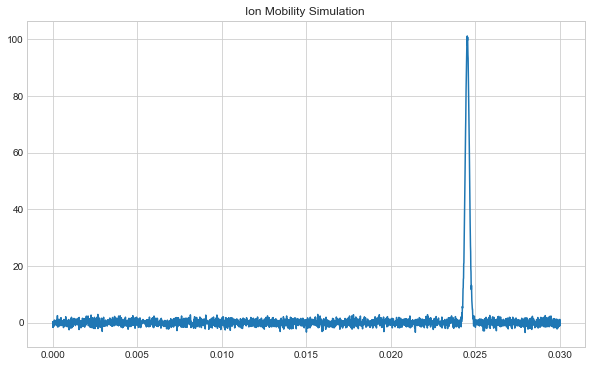

In [25]:
plt.subplots(figsize=(10, 6))
plt.plot(x, y)
plt.title("Ion Mobility Simulation ")

## Eqn #7:    ## $$\mathrm{v_d}=\dfrac{3}{4}\bigg(\dfrac{zeE}{\mu\Omega\mathrm{v_t}N}\bigg) = \dfrac{L}{t_d}$$

In [26]:
vd = (DL / 100.0) / dt  #m/s
vd

4.078303425774878

In [27]:
ionMass = 527.0
gasMass = 28.0
reducedMass = ((ionMass * gasMass) / (ionMass + gasMass))
vt = calcThermalVelocity(T + 273.15, reducedMass)  #m/s
vt

580.4925583237939

In [28]:
velRatio = vd / vt
velRatio

0.0070255912281652951

____

## Beginning of Equations and Approach to Mobility Field Correction

## ${\beta}$ Coefficient

In [29]:
vdvtRatio = np.linspace(0, 1, 100)

In [30]:
def calcBeta(vdvtRatio):
    beta = (2 * np.sqrt(2 * (1 + vdvtRatio**2))) / (
    (1 + vdvtRatio) + np.sqrt((1 + vdvtRatio**2) * (
        (1 - 2 * vdvtRatio)**2) + 2 * vdvtRatio))
    return beta

In [31]:
beta = calcBeta(vdvtRatio)

Text(0.5,1,'Drift Velocity/Thermal Velocity Ratio vs. Beta')

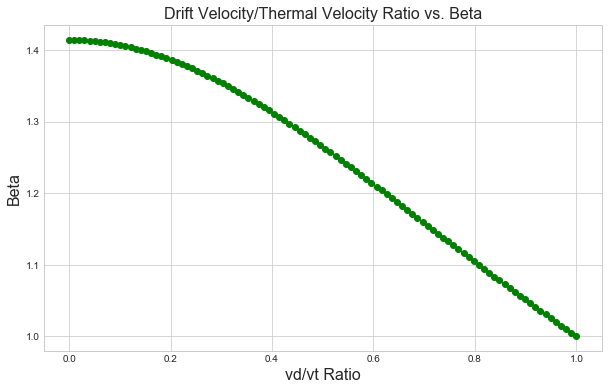

In [32]:
plt.subplots(figsize=(10, 6))
plt.ylabel("Beta", fontsize = 16)
plt.xlabel("vd/vt Ratio", fontsize = 16)
plt.plot(vdvtRatio, beta, 'go-')
plt.title("Drift Velocity/Thermal Velocity Ratio vs. Beta", fontsize = 16)

## Ratio of $v_d/v_t$ to the number of cooling collisions
* Fraction of cooling collisions as a function of vd/vT. The values are obtained by numerical integration. See ESI2 in the BLH Paper in Analyst.


In [33]:
betaSlope = np.diff(beta) / np.diff(vdvtRatio)

Text(0.5,1,'vd/vt Ratio vs. Cooling Fraction')

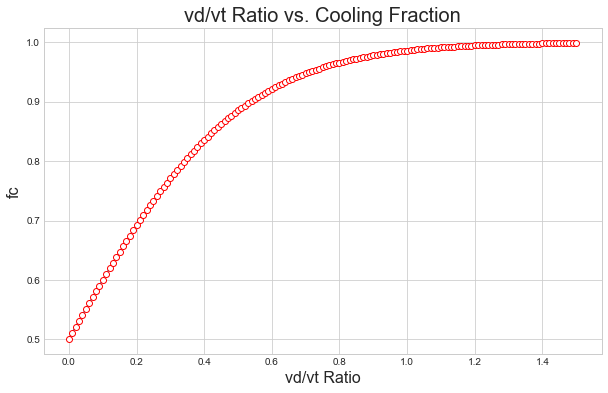

In [34]:
plt.subplots(figsize=(10, 6))

vdvtfc = np.loadtxt('velocityRatio.csv', skiprows=1, delimiter=',')
vdvtCalc = vdvtfc[:, 0]
fcCalc = vdvtfc[:, 1]
plt.plot(vdvtCalc, fcCalc, 'o-', mfc='white', mec='red', mew=1.0)
plt.xlabel('vd/vt Ratio', fontsize=16)
plt.ylabel('fc', fontsize=16)
plt.title("vd/vt Ratio vs. Cooling Fraction", fontsize = 20)

In [35]:
f = interpolate.UnivariateSpline(vdvtCalc, fcCalc, s=0)
xnew = np.linspace(vdvtCalc.min(), vdvtCalc.max(),
                   len(vdvtCalc) * 100)  #increase the length of vdvtCalc
fcCalcNew = f(xnew)

## The following places the cooling fraction integration into memory as a function to call directly when calculating the correction factors.

Text(0.5,1,'vd/vt Ratio vs. Cooling Fraction')

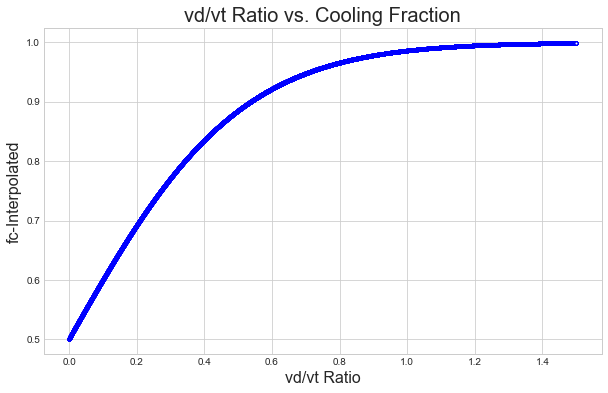

In [36]:
plt.subplots(figsize=(10, 6))
plt.plot(xnew, fcCalcNew, '.-', mfc='white', mec='blue', mew=1.0)
plt.xlabel('vd/vt Ratio', fontsize=16)
plt.ylabel('fc-Interpolated', fontsize=16)
plt.title("vd/vt Ratio vs. Cooling Fraction", fontsize = 20)

In [37]:
from scipy.interpolate import interp1d


def NearestValue(array, value):
    #returns the index of the element of the array which is closest to value

    idx = (np.abs(array - value)).argmin()
    return idx

In [38]:
fcInterp = np.interp(velRatio, xnew, fcCalcNew)
print(velRatio, fcInterp)

0.00702559122817 0.5083221838701071


#### $\dfrac{E}{N}$ Corrected Equation: $\quad \Omega_{MT}=\dfrac{3}{4}\bigg(\dfrac{zeE}{\mu{v_d}{v_T}N}\bigg)\cdot\bigg(1+\bigg(\dfrac{\color{red}\beta}{\color{blue}\alpha}\bigg)^2\bigg(\dfrac{v_d}{v_t}\bigg)^2\bigg)^{-1/2}$

### Origianl Zero Field Equation

####     $$\Omega=\bigg(\dfrac{3}{16}\bigg)\bigg(\dfrac{2\pi}{\mu\mathrm{k_{b}}\mathrm{T}}\bigg)^{\frac{1}{2}}\bigg(\dfrac{ze}{KN}\bigg)=\dfrac{3}{4}\bigg(\dfrac{zeE}{\mu\mathrm{v_d}\mathrm{v_T}N}\bigg)$$

#### $(1)\quad \Omega_{MT}=\dfrac{3}{4}\bigg(\dfrac{{\color{blue}\alpha}\cdot ze}{\mu\cdot(\mathrm{v_T+{\color{green}\beta} v_d)}}\bigg)\bigg(\dfrac{eE}{v_d\cdot N}\bigg)\cdot{\color{red}\zeta_{mt}}$

#### $(1)\quad \Omega_{MT}=\dfrac{3}{4}\bigg(\dfrac{zeE}{\mu{v_d}{v_T}N}\bigg)\cdot\bigg(1+\bigg(\dfrac{\color{red}\beta}{\color{blue}\alpha}\bigg)^2\bigg(\dfrac{v_d}{v_t}\bigg)^2\bigg)^{-1/2}$

#### $(2)\quad {\color{blue}\alpha} = \frac{2}{3}\big[1+ \hat{m}\cdot f_c+\hat{M}\cdot f_h\big]$

#### $(3)\quad \dfrac{2}{3}\le{\color{blue}\alpha}\le\dfrac{4}{3}$

#### $(4)\quad {\color{green}\beta} =\sqrt{\frac{2}{\hat{m}(1+\hat{m})}} $

#### $(5)\quad {\color{red}\zeta_{mt}}={\Big[1+\Big(\frac{{\color{green}\beta} v_d}{{\color{blue}\alpha} v_T}\Big)\Big]}^{-1/2}$

In [39]:
def calcAlpha(m, M, fc):
    mhat = m / (m + M)
    Mhat = M / (m + M)
    alpha = (2 / 3.0) * (1 + mhat * fc + Mhat * (1 - fc))
    return alpha

In [79]:
calcAlpha(533.0, 28.0, 0.508322)

1.0049941889483065

### Transverse Velocity Coefficient $\beta_{MT}$

In [41]:
def calcTransverseVelCoeff(m, M):
    '''
    Also known as $beta_MT$
    '''
    mhat = m * 1.0 / (m + M)
    return np.sqrt(2.0 / mhat / (1 + mhat))

In [80]:
calcTransverseVelCoeff(527, 28)

1.0394151508832672

## $v_r = (v_t^2 + \frac{\beta}{\alpha})^2v_d^2)^{1/2} (m s^{-1})$

In [43]:
def calcVR(vd, vT, beta, alpha):
    vr = np.sqrt(vT**2 + (beta / alpha)**2 * vd**2)
    return vr

In [44]:
calcVR(37.3114, 465.43, 1.022, 0.978)

467.06028246449392

## $\zeta_{mt}={\Big[1+\Big(\frac{\beta v_d}{\alpha v_T}\Big)\Big]}^{-1/2}$

In [178]:
def zetaMT(vd, vT, beta, alpha):
    '''
    Momentum transfer fraction coefficient
    '''
    return 1.0 / np.sqrt(1 + ((beta * vd) / (alpha * vT))**2)

In [179]:
zetaMT(4.078, 580.49, 1.0394, 1.00498)

0.99997360580904282

### In summary, it is necessary to input the charge, drift velocity, the thermal velocity of the gas, number density, electric field, and reduced mass. 

In [243]:
def calcCorrectedCCS(ionMass, ionCharge, gasMass, driftLength, driftPotential, driftTime, gasPress, gasTemp, fcList = [xnew, fcCalcNew], debug = True):
    '''
    ccs is in square angstroms
    pressure is in torr
    length is in cm
    Temp is in Kelvin
    ionMass and gasMass are in amu
    drift time is in seconds
    potential is in Volts
    '''
    #Scale some of the input values to get them in SI units
    driftLength /= 100.0 #in m
    massConv = 1.660539E-24  #gm/amu
    
    reducedMass = ((ionMass * gasMass) / (ionMass + gasMass))
    vt = calcThermalVelocity(gasTemp, reducedMass)  #m/s
    vd = driftLength/driftTime
    velRatio = vd/vt
    fc = np.interp(velRatio, fcList[0], fcList[1])
    
    alpha = calcAlpha(ionMass, gasMass, fc)
    beta = calcTransverseVelCoeff(ionMass, gasMass)#calcBeta(velRatio)
    numDens = calcNumberDensity(gasPress, gasTemp, No=2.68677E25)
    
    ccsRaw = ccsFromDriftTime(driftPotential, driftLength, gasPress, gasTemp, driftTime, ionCharge, ionMass, gasMass, False)

    eField = driftPotential / (driftLength)  #V/m
    corrCCS = ccsRaw*1.0/np.sqrt(1+((beta/alpha)**2)*((vd/vt)**2))

    if debug:
        print("E-Field: ", eField / 100, 'V/cm')
        print("Drift Velocity: ", vd)
        print("Thermal Velocity: ", vt)
        print("Number Density: ", numDens)
        print('fc: ', fc)
        print("Alpha: ", alpha)
        print("Beta: ", beta)
#         print("Zeta: ", zeta)
        print("E/N :", eField/numDens*1E17*1E4)#Convert to townsend and get rid of cm
    
    return corrCCS*1E-4#scaling factor for dimensions


In [245]:
T = 373.15
P = 700
gasMass = 30.0
driftTime = 16.39/1000#convert to seconds
DL = 20.99 #cm
DV = DL*550
ionMass = 226.0

In [246]:
ccsFromDriftTime(DV, DL, P, T, driftTime, 1, ionMass, gasMass, True)

Drift Velocity in m/s: 12.80658938377059
E-Field:  550.0000000000001 V/cm
Drift Velocity 12.80658938377059 m/s
Thermal Velocity:  546.177964322
Number Density:  1.8114764693540766e+25
Numerator:  3.64839327068741e-23
Denominator:  3.07614262817e-19


118.60286442097711

In [247]:
corrCCS = calcCorrectedCCS(ionMass, 1, gasMass, DL, DV, driftTime, P, T)
print(corrCCS)

E-Field:  550.0000000000001 V/cm
Drift Velocity:  12.80658938377059
Thermal Velocity:  546.177964322
Number Density:  1.8114764693540766e+25
fc:  0.5249283761538448
Alpha:  1.012723858661858
Beta:  1.09692573211
E/N : 3.036197319174205
118.564632499


In [248]:
def calcCorrectedCCSfromTable(ionMass, ionCharge, gasMass, driftLength, driftPotential, redMob, gasPress, gasTemp, fcList = [xnew, fcCalcNew], debug = True):
    '''
    ccs is in square angstroms
    pressure is in torr
    length is in cm
    Temp is in Kelvin
    ionMass and gasMass are in amu
    redMob is in cm^2/Vs
    potential is in Volts
    '''
    #Scale some of the input values to get them in SI units
    driftLength /= 100.0 #in m
    massConv = 1.660539E-24  #gm/amu
    
    reducedMass = ((ionMass * gasMass) / (ionMass + gasMass))
    vt = calcThermalVelocity(gasTemp, reducedMass)  #m/s
    driftTime = driftTimeFromReducedMobility(redMob, gasPress, gasTemp, driftLength*100, driftPotential)
#     print(driftTime)
    vd = driftLength/driftTime
    velRatio = vd/vt
    fc = np.interp(velRatio, fcList[0], fcList[1])
    
    alpha = calcAlpha(ionMass, gasMass, fc)
    beta = calcTransverseVelCoeff(ionMass, gasMass)#calcBeta(velRatio)
    numDens = calcNumberDensity(gasPress, gasTemp, No=2.68677E25)
    
    eField = driftPotential / (driftLength)  #V/m
    
    
    ccsRaw = ccsFromDriftTime(driftPotential, driftLength, gasPress, gasTemp, driftTime, ionCharge, ionMass, gasMass, False)
#     print(ccsRaw)
    corrCCS = ccsRaw*1.0/np.sqrt(1+((beta/alpha)**2)*((vd/vt)**2))

    
    if debug:
        print("E-Field: ", eField / 100, 'V/cm')
        print("Drift Velocity: ", vd)
        print("Thermal Velocity: ", vt)
        print("Number Density: ", numDens)
        print('fc: ', fc)
        print("Alpha: ", alpha)
        print("Beta: ", beta)
#         print("Zeta: ", zeta)
        print("E/N :", eField/numDens*1E17*1E4)#Convert to townsend and get rid of cm
    
    return corrCCS*1E-4#scaling factor for dimensions


In [249]:
redMob = 1.570
ccsMT = calcCorrectedCCSfromTable(ionMass, 1, gasMass, DL, DV, redMob, P, T)
print(ccsMT)

E-Field:  550.0000000000001 V/cm
Drift Velocity:  12.807375277843153
Thermal Velocity:  546.177964322
Number Density:  1.8114764693540766e+25
fc:  0.5249298142145195
Alpha:  1.012724592671994
Beta:  1.09692573211
E/N : 3.036197319174205
118.557352428


### $$\quad \Omega_{MT}=\dfrac{3}{4}\bigg(\dfrac{zeE}{\mu{v_d}{v_T}N}\bigg)\cdot\bigg(1+\bigg(\dfrac{\color{red}\beta}{\color{blue}\alpha}\bigg)^2\bigg(\dfrac{v_d}{v_t}\bigg)^2\bigg)^{-1/2}$$

______

#### Sanity Check from [Zhang et al. ACP Manuscript](https://www.atmos-chem-phys.net/16/12945/2016/)
* doi:10.5194/acp-16-12945-2016

#### Code translated from matlab supplied by Zhang in the supplementary material

In [153]:
# Constants
q = 1.6e-19; # Ionic charge; unit: kg m2 V-1 s-2
kb = 1.3806e-23; # Boltzman constant; unit: m2 kg s-2 K-1
N0 = 2.69e25; # Number density of an ideal gas at 0 ∞C and 1 atm; unit: m-3
T0 = 273.15; # Standard temperature; unit: K
P0 = 760; # Standard pressure; unit: mbar
M = 30; # N2 molecular weight; unit: amu
fc = 0.52493; # Fraction of collisions in the cooling classes;
fh = 1.0-fc; # Fraction of collisions in the heating classes;
# Instrument parameters
# !! Need to be constrained using instrument standard by Equation (5) !!
L = 21.0; # Drift tube length; unit: cm
T = 373.15; # Drift tube temperature; unit: K
P = 700; # Drift tube pressure; unit: mbar
Ud = DV; # Potential gradient on the drift tube; unit: V
print("Drift Voltage: ", Ud)
print("E-Field", Ud/L)
# Measurements
m = ionMass; # Molecular weight of the ion; unit: amu
z = 1; # Number of charges on the ion;
# slope = 200.51; # Linear regression of Equation (3)
# Calculations
# K0 = (T0/T)*(P/P0)*(L**2./slope); # Reduced ion mobility constant; unit (cm^2/s/V)
K0 = 1.570
Vd = (Ud/L)*K0/100; # Drfit velocity of the ion; unit: m s-1
# Vd = 4.07
print("Drift Velocity: ", Vd)
Vt = ((8*kb*T)/(3.14*1.66E-27*(m*M)/(m+M)))**0.5; # Termal velocity of the ion; unit: m s-1
print("Thermal Velocity: ", Vt)
alpha = (2/3)*(1+fc*m/(m+M)+fh*M/(m+M)); # Correction coefficients for collision frequency
print("Alpha: ", alpha)
beta = (2./(m/(m+M))/(1+(m/(m+M))))**0.5; # Correction coefficients for momentum transfer
print("beta: ", beta)

CCS = 10**20*(3*z*q/16/N0)*(2*3.14/kb/T0)**0.5*((m+M)/m/M/1.66e27)**0.5*(10**4./K0)*(1+(beta/alpha)**2*(Vd/Vt)**2)**0.5 # Collision cross section; unit: A^2
print(CCS)

Drift Voltage:  11550
E-Field 550.0
Drift Velocity:  8.635
Thermal Velocity:  546.3952543355338
Alpha:  1.0127246875
beta:  1.0969257321091987
1.3827043079385826e-25


______

#### Mean Free Path Calculation

## ${\lambda}_1 =\dfrac{1}{n_1\pi{\sigma}_{11}^2 + n_2\pi{\sigma}_{12}^2\sqrt{1+m_1/m_2}}$

If $n_1\ll n_2$ only the primary gas will dominate
(Chapman and
Cowling, 1970)

When only one gas is present, the familiar formula λ1 = 1/(
√
2nπσ2
) is recovered. When n1 << n2,
the first term in the denominator, resulting from like-molecule collisions, is negligible. With this
expression, the mean free path of H2O in a dry CO2 atmosphere at 600 Pa and 200 K is λ1 ≈ 9 µm.

---

(0.18258905014552554, -0.0816164123626784)
(0.9129452507276277, -0.40808206181339196)


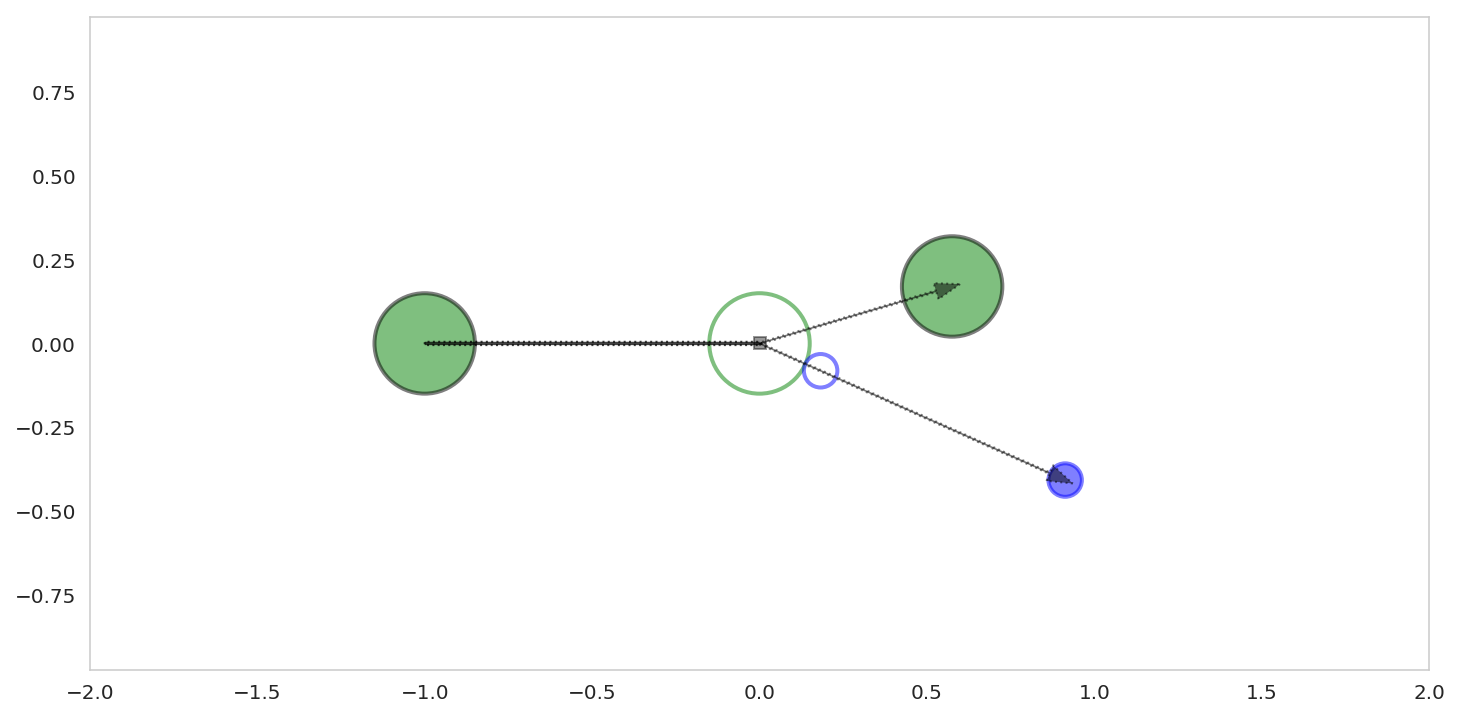

In [51]:
fig, ax = plt.subplots(figsize=(12, 6))

mSize = 0.15
mLoc = [-1.0, 0.0]

#original location of m
c = plt.Circle(mLoc, color='g', radius=mSize, alpha=0.5, ec='k', lw=2.0)
ax.add_patch(c)

plt.arrow(
    -1,  #x1
    0.0,  # y1
    1,  # x2 - x1
    0,  # y2 - y1
    color='k',
    width=0.01,
    head_width=0.005,
    alpha=0.75,
    linestyle=':')

#collision location of m
cLoc = [0, 0]
c = plt.Circle(cLoc, color='white', radius=mSize, alpha=0.5, ec='g', lw=2.0)
ax.add_patch(c)

#collision location of M
phi = 20.0
gSize = 0.05
gLocX = (mSize + gSize) * np.sin(phi)
gLocY = -1 * (mSize + gSize) * np.cos(phi)
print(gLocX, gLocY)
gLoc = [gLocX, gLocY]
c = plt.Circle(gLoc, color='white', radius=gSize, alpha=0.5, ec='b', lw=2.0)
ax.add_patch(c)

#post-collision location of M
phi = 20.0
gSize = 0.05
gDist = 1
gLocX = (gDist) * np.sin(phi)
gLocY = -1 * (gDist) * np.cos(phi)
print(gLocX, gLocY)
gLoc = [gLocX, gLocY]
c = plt.Circle(gLoc, color='blue', radius=gSize, alpha=0.5, ec='b', lw=2.0)
ax.add_patch(c)

plt.arrow(
    0,  #x1
    0,  # y1
    (gDist - 0.05) * np.sin(phi),  # x2 - x1
    -1 * (gDist - 0.05) * np.cos(phi),  # y2 - y1
    color='k',
    width=0.005,
    head_width=0.05,
    alpha=0.5,
    linestyle=':')

#post-collision location of m
zeta = 5.0
mDist = 0.6
mLocX = -1 * (mDist) * np.sin(zeta)
mLocY = (mDist) * np.cos(zeta)
mLoc = [mLocX, mLocY]
c = plt.Circle(mLoc, color='g', radius=mSize, alpha=0.5, ec='k', lw=2.0)
ax.add_patch(c)

plt.arrow(
    0,  #x1
    0,  # y1
    -1 * (mDist - 0.05) * np.sin(zeta),  # x2 - x1
    (mDist - 0.05) * np.cos(zeta),  # y2 - y1
    color='k',
    width=0.005,
    head_width=0.05,
    alpha=0.5,
    linestyle=':')

plt.plot(0.0, 0.0, 'sk', alpha=0.4)

plt.axis('equal')

plt.xlim(-2, 2)
plt.ylim(-1, 1)
plt.grid()